# ESC-50 Edge Audio Baseline Notebook

本Notebook按照"小步快跑"策略，用于：
1. 检查并理解ESC-50数据，确认枪声/玻璃破碎/背景样本规模。
2. 先行搭建梅尔谱特征提取与可视化helper，为后续CNN训练做准备。
3. 后面再逐步补充模型训练与评估单元。

## Imports and shared helpers
加载所有依赖与项目模块，保持 Notebook 本体只关注流程。

In [1]:
from pathlib import Path
from typing import List
import random

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import (
    PROJECT_ROOT,
    DATA_ROOT,
    AUDIO_DIR,
    META_FILE,
    CACHE_DIR,
    POSITIVE_LABELS,
    BACKGROUND_LABEL,
    BACKGROUND_MULTIPLIER,
    WINDOW_SECONDS,
    WINDOW_HOP,
    SR,
    N_MELS,
    N_FFT,
    HOP_LENGTH,
    SEED,
)
from src.data_utils import (
    build_dataset,
    load_audio,
    log_mel_spectrogram,
    generate_aligned_windows,
)
from src.folds import assign_folds, fold_summary
from src.viz import plot_wave_and_mel
from src.cache_utils import (
    build_cache_index,
    GLASS_PIPELINE_PLAN,
    GLASS_LABELS,
    sample_background_chunk,
)
from src.augment_pipeline import PIPELINE_REGISTRY, run_pipeline

sns.set_theme(style='whitegrid')
from src.audio_qc import export_mel_to_wav
from IPython.display import Audio, display


## 加载元数据并构建数据集
打印路径并构建玻璃/背景数据子集，这是后续流程的基准。

In [2]:
print(f'Project root: {PROJECT_ROOT}')
print(f'Metadata file: {META_FILE}')
print(f'Cache dir: {CACHE_DIR}')

meta_df = pd.read_csv(META_FILE)
dataset_df = build_dataset(meta_df)
print(f'Total selected samples: {len(dataset_df)}')
dataset_df['target_label'].value_counts().to_frame('count')

Project root: /workspace
Metadata file: /workspace/data/meta/esc50.csv
Cache dir: /workspace/cache/mel64
Total selected samples: 160


,count
target_label,
background,120
glass_breaking,40


## Fold assignment
基于 ESC-50 原生的 `fold` 字段补充 `fold_id`，方便之后做交叉验证，并输出分布。

In [3]:
dataset_df['fold_id'] = assign_folds(dataset_df)
fold_counts = fold_summary(dataset_df, fold_column='fold_id', label_column='target_label')
fold_counts

,fold_id,target_label,count
0,1,background,27
1,1,glass_breaking,8
2,2,background,23
3,2,glass_breaking,8
4,3,background,22
5,3,glass_breaking,8
6,4,background,25
7,4,glass_breaking,8
8,5,background,23
9,5,glass_breaking,8


## 可视化随机样本
抽一条记录画出波形与 log-mel，用肉眼确认数据质量。

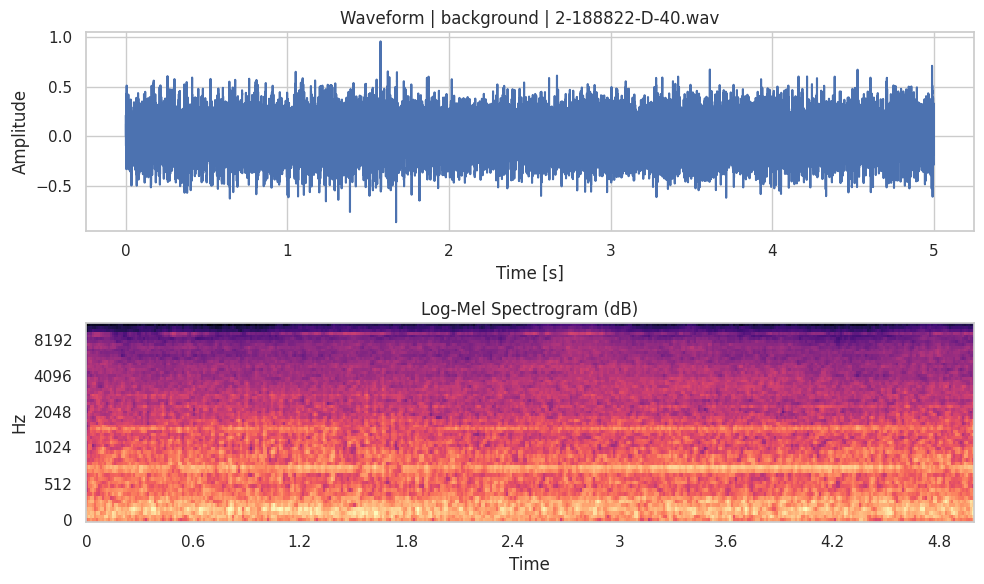

In [4]:
sample_row = dataset_df.sample(random_state=SEED).iloc[0]
plot_wave_and_mel(sample_row)

## 增强管线规划
定义每个增强组合并展示 demo 输出，方便理解后续批量增强的效果与元信息。

In [5]:
PIPELINE_PLAN = GLASS_PIPELINE_PLAN
GLASS_TARGETS = list(GLASS_LABELS)

def demo_glass_augmentation(pipeline_name: str):
    glass_row = dataset_df[dataset_df['target_label'].isin(GLASS_TARGETS)].sample(random_state=SEED).iloc[0]
    base_window = generate_aligned_windows(glass_row, align_labels=GLASS_TARGETS)[0]
    background = None
    if 'mix' in PIPELINE_REGISTRY[pipeline_name]:
        background = sample_background_chunk(dataset_df, len(base_window))
    augmented = run_pipeline(base_window, pipeline_name, background=background)
    return glass_row, base_window, augmented

DEMO_PIPELINE = 'shift_mix'
demo_row, base_window, demo_augmented = demo_glass_augmentation(DEMO_PIPELINE)
metadata_stub = {
    'source_filename': demo_row['filename'],
    'fold_id': int(demo_row['fold_id']),
    'pipeline': DEMO_PIPELINE,
    'augment_desc': demo_augmented.description,
}
print(f"Demo pipeline: {demo_augmented.description}")
print(f"Base window shape: {base_window.shape}, augmented shape: {demo_augmented.audio.shape}")
metadata_stub

Demo pipeline: shift_mix(time_shift+mix)
Base window shape: (22050,), augmented shape: (22050,)


{'source_filename': '3-203375-A-39.wav',
 'fold_id': 3,
 'pipeline': 'shift_mix',
 'augment_desc': 'shift_mix(time_shift+mix)'}

## 缓存配置与抽样验证
先在极小样本上运行新缓存管线，验证峰值对齐/增强/索引输出是否符合预期。

In [6]:
CACHE_EXTRA_SHIFTS = (-0.1, 0.1)
SMOKE_CACHE_DIR = CACHE_DIR / 'dev_smoke'
SMOKE_CACHE_DIR.mkdir(parents=True, exist_ok=True)

smoke_df = dataset_df.groupby('target_label').head(1).copy()
smoke_cache_index = build_cache_index(
    smoke_df,
    pipeline_plan=PIPELINE_PLAN,
    cache_dir=SMOKE_CACHE_DIR,
    align_labels=GLASS_TARGETS,
    extra_shifts=CACHE_EXTRA_SHIFTS,
    seed=SEED,
)
print(f"Smoke cache entries: {len(smoke_cache_index)}")
smoke_cache_index.head()

Smoke cache entries: 42


,path,label,fold_id,source_filename,pipeline_name,augment_desc
0,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,base,base
1,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,shift_gain,shift_gain(time_shift+gain)
2,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,shift_gain,shift_gain(time_shift+gain)
3,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,shift_gain,shift_gain(time_shift+gain)
4,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,stretch_reverb,stretch_reverb(time_stretch+reverb)


## 全量缓存与索引输出
在主缓存目录生成全部 mel 及索引，供训练和 QA 使用（运行时间视机器性能而定）。

In [7]:
CACHE_OUTPUT_DIR = CACHE_DIR
cache_index_df = build_cache_index(
    dataset_df,
    pipeline_plan=PIPELINE_PLAN,
    cache_dir=CACHE_OUTPUT_DIR,
    align_labels=GLASS_TARGETS,
    extra_shifts=CACHE_EXTRA_SHIFTS,
    seed=SEED,
)
print(f"Total cached entries: {len(cache_index_df)}")
print(cache_index_df['label'].value_counts())
cache_index_df.head()

Total cached entries: 2400
label
glass_breaking    1320
background        1080
Name: count, dtype: int64


,path,label,fold_id,source_filename,pipeline_name,augment_desc
0,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,base,base
1,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,shift_gain,shift_gain(time_shift+gain)
2,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,shift_gain,shift_gain(time_shift+gain)
3,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,shift_gain,shift_gain(time_shift+gain)
4,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,stretch_reverb,stretch_reverb(time_stretch+reverb)


## QA 抽样列表
从索引中抽取若干增强样本，记录路径、fold、pipeline，便于后续手动试听确认音质。

In [8]:
QA_SAMPLE_COUNT = 10
qa_samples = cache_index_df[cache_index_df['label'].isin(GLASS_TARGETS)].sample(
    n=min(QA_SAMPLE_COUNT, len(cache_index_df)),
    random_state=SEED,
)
qa_samples[['path', 'fold_id', 'pipeline_name', 'augment_desc']]

,path,fold_id,pipeline_name,augment_desc
678,/workspace/cache/mel64/glass_breaking/fold3/3-...,3,shift_mix,shift_mix(time_shift+mix)
693,/workspace/cache/mel64/glass_breaking/fold3/3-...,3,base,base
610,/workspace/cache/mel64/glass_breaking/fold3/3-...,3,stretch_reverb,stretch_reverb(time_stretch+reverb)
49,/workspace/cache/mel64/glass_breaking/fold1/1-...,1,stretch_reverb,stretch_reverb(time_stretch+reverb)
1291,/workspace/cache/mel64/glass_breaking/fold5/5-...,5,stretch_reverb,stretch_reverb(time_stretch+reverb)
486,/workspace/cache/mel64/glass_breaking/fold2/2-...,2,shift_gain,shift_gain(time_shift+gain)
548,/workspace/cache/mel64/glass_breaking/fold3/3-...,3,filter_gain,filter_gain(filter+gain)
940,/workspace/cache/mel64/glass_breaking/fold4/4-...,4,stretch_reverb,stretch_reverb(time_stretch+reverb)
78,/workspace/cache/mel64/glass_breaking/fold1/1-...,1,shift_gain,shift_gain(time_shift+gain)
506,/workspace/cache/mel64/glass_breaking/fold2/2-...,2,base,base


## QA 音频试听
将抽样列表中的部分 mel 片段还原为 wav，便于实际聆听确认增强是否合理。

In [10]:
QA_AUDIO_DIR = CACHE_OUTPUT_DIR / 'qa_audio'
QA_AUDIO_DIR.mkdir(parents=True, exist_ok=True)

qa_audio_samples = []
for idx, row in qa_samples.iterrows():
    mel_path = Path(row['path'])
    wav_path = QA_AUDIO_DIR / f"{mel_path.stem}.wav"
    export_mel_to_wav(mel_path, wav_path)
    qa_audio_samples.append((row, wav_path))

print(f"Generated {len(qa_audio_samples)} QA audio snippets at {QA_AUDIO_DIR}")
for row, wav_path in qa_audio_samples:
    display(Audio(filename=wav_path, rate=SR))
    print(f"Label: {row['label']} | Fold: {row['fold_id']} | Pipeline: {row['pipeline_name']} | Desc: {row['augment_desc']}File: {wav_path}")


Generated 10 QA audio snippets at /workspace/cache/mel64/qa_audio


Label: glass_breaking | Fold: 3 | Pipeline: shift_mix | Desc: shift_mix(time_shift+mix)File: /workspace/cache/mel64/qa_audio/3-203377-A-39_shift_mix_w01_c01.wav


Label: glass_breaking | Fold: 3 | Pipeline: base | Desc: baseFile: /workspace/cache/mel64/qa_audio/3-216280-A-39_base_w00.wav


Label: glass_breaking | Fold: 3 | Pipeline: stretch_reverb | Desc: stretch_reverb(time_stretch+reverb)File: /workspace/cache/mel64/qa_audio/3-203374-A-39_stretch_reverb_w01_c01.wav


Label: glass_breaking | Fold: 1 | Pipeline: stretch_reverb | Desc: stretch_reverb(time_stretch+reverb)File: /workspace/cache/mel64/qa_audio/1-84536-A-39_stretch_reverb_w01_c01.wav


Label: glass_breaking | Fold: 5 | Pipeline: stretch_reverb | Desc: stretch_reverb(time_stretch+reverb)File: /workspace/cache/mel64/qa_audio/5-260434-A-39_stretch_reverb_w00_c00.wav


Label: glass_breaking | Fold: 2 | Pipeline: shift_gain | Desc: shift_gain(time_shift+gain)File: /workspace/cache/mel64/qa_audio/2-173618-A-39_shift_gain_w02_c01.wav


Label: glass_breaking | Fold: 3 | Pipeline: filter_gain | Desc: filter_gain(filter+gain)File: /workspace/cache/mel64/qa_audio/3-203371-A-39_filter_gain_w01_c00.wav


Label: glass_breaking | Fold: 4 | Pipeline: stretch_reverb | Desc: stretch_reverb(time_stretch+reverb)File: /workspace/cache/mel64/qa_audio/4-204777-A-39_stretch_reverb_w01_c01.wav


Label: glass_breaking | Fold: 1 | Pipeline: shift_gain | Desc: shift_gain(time_shift+gain)File: /workspace/cache/mel64/qa_audio/1-84704-A-39_shift_gain_w01_c00.wav


Label: glass_breaking | Fold: 2 | Pipeline: base | Desc: baseFile: /workspace/cache/mel64/qa_audio/2-250710-A-39_base_w01.wav
